In [8]:
import numpy as np


# Word2Id

In [10]:
def preprocess(text):
    text = text.lower().replace('.', ' .')
    words = text.split(' ')    

    words_sorted = sorted(list(set(words)))
    word_indices = dict((c, i) for i, c in enumerate(words_sorted))
    indices_word = dict((i, c) for i, c in enumerate(words_sorted))
    corpus = np.array([ word_indices[w] for w in words ])

    return corpus, word_indices, indices_word


In [13]:
sent_ids, word_ids, ids_word = preprocess('you say goodbye and i say hello.')


# co-occurence matrix

In [14]:
def create_co_matrix(sent_ids, vocabulary_size, window_size=1):
    co_matrix = np.zeros((vocabulary_size, vocabulary_size))
    M = len(sent_ids)

    for idx, word_id in enumerate(sent_ids):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = sent_ids[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx <= M - 1:
                right_word_id = sent_ids[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix


In [17]:
C = create_co_matrix(sent_ids, len(set(sent_ids)))


# similarity

In [16]:
def cos_similarity(x, y):
    eps = 1e-8
    nx = x / np.sqrt(np.sum(x**2) +eps)
    ny = y / np.sqrt(np.sum(y**2) +eps)
    
    return nx@ny


In [51]:

w1_v = C[word_ids['you']]
w2_v = C[word_ids['i']]

cos_similarity(w1_v, w2_v)


0.7071067758832467

In [55]:
def most_similar(word, word_ids, ids_word, co_matrix, N=5):
    if word not in word_ids.keys():
        print(f'{word} doesn\'t exit!')
        return
    
    word_v = co_matrix[word_ids[word]]
    similarity = np.array([cos_similarity(word_v, co_matrix[w_id]) for (w_id, w) in ids_word.items()])

    sorted_index = (-1 * similarity).argsort()
    names = [ids_word[i] for i in sorted_index[:N]]
    prob = [(n, s) for n, s in zip(names, similarity[sorted_index])] 
    return prob
    

In [57]:
most_similar('you', word_ids, ids_word, C)

[('you', 0.9999999900000001),
 ('goodbye', 0.7071067758832467),
 ('hello', 0.7071067758832467),
 ('i', 0.7071067758832467),
 ('.', 0.0)]

# PMI

In [62]:
def PMI(C, eps=1e-8):
    pmi = np.zeros_like(C)

    total_freqs = np.sum(C) # total occurances of words
    word_freq = np.sum(C, axis=1)
    
    word_len, context_len = C.shape
    for i in range(word_len):
        for j in range(context_len):
            pmi_x = np.log2(C[i, j]*total_freqs /(word_freq[i]*word_freq[j]) + eps)
            pmi[i, j] = max(0, pmi_x)

    return pmi


In [68]:
ppmi = PMI(C)


In [69]:
C


array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [70]:
ppmi

array([[0.        , 0.        , 0.        , 2.80735492, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 1.80735493, 0.        , 1.80735493,
        0.        , 0.        ],
       [0.        , 1.80735493, 0.        , 0.        , 0.        ,
        0.80735493, 0.        ],
       [2.80735492, 0.        , 0.        , 0.        , 0.        ,
        0.80735493, 0.        ],
       [0.        , 1.80735493, 0.        , 0.        , 0.        ,
        0.80735493, 0.        ],
       [0.        , 0.        , 0.80735493, 0.80735493, 0.80735493,
        0.        , 1.80735493],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.80735493, 0.        ]])

# Dimensionality Reduction

In [92]:
U, S, Vt = np.linalg.svd(ppmi)

U_trunc = -1 * U[:, :2]


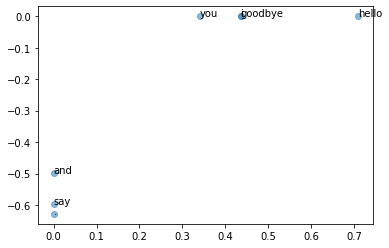

In [91]:
import matplotlib.pyplot as plt

for word, word_id in word_ids.items():
    plt.annotate(word, (U_trunc[word_id, 0], U_trunc[word_id, 1]))

plt.scatter(U_trunc[:,0], U_trunc[:, 1], alpha=0.5)
